# 电力大数据：企业电力用电量预测

# 背景

精细化电量预测是中长期电量预测发展的一个重要趋势。针对目前我国的中长期电量预测的预测对象主要是总电量，预测结果准确度难以进一步提高，且提供的信息十分有限的问题，本文开展了基于企业用电行业的中长期电量预测研究。
 


# 思路

（1）精细化电量预测是中长期电量预测的重要指标，特别是对核心用电大户的电量预测可以对长期的电力发展规划起到十分重要的作用。本研究主要侧重于“有色金属”和“橡胶”两大用点巨头的用电预测。

（2）用电预测本质上是一种时间序列的预测，类似的时间序列例子包括：股票债券等金融产品的价格趋势预测、网络流量预测、人口和经济增长预测等。

（3）企业用电预测和股票预测类似，主要会受到大环境和企业自身发展的影响，在时间上具有周期性、波动性。



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# 一、数据加载及预览

In [31]:
# 加载数据
consumption = pd.read_excel('data/Daliy_consumption.xlsx')
consumption.head()

,客户名称,时间,电量(KWH)
0,昆明市官渡区荣宏塑料厂,2015-09-01,1596.98
1,昆明市官渡区荣宏塑料厂,2015-09-02,1658.23
2,昆明市官渡区荣宏塑料厂,2015-09-03,1634.56
3,昆明市官渡区荣宏塑料厂,2015-09-04,1586.91
4,昆明市官渡区荣宏塑料厂,2015-09-05,1543.75


In [48]:
consumption[consumption['电量(KWH)']==min(consumption['电量(KWH)'])]

,客户名称,时间,电量(KWH)
1081,云南铝业股份有限公司,2016-09-15,-8.0


In [49]:
consumption['电量(KWH)'] = consumption['电量(KWH)'].apply(lambda x: 0 if x<0 else x)

In [50]:
# 股票数据
yunnan_2015 = pd.read_csv('data/sz_hq_000807_2015_2017/sz_hq_000807_2015.csv',encoding='gbk')
yunnan_2015.index = yunnan_2015['交易日期']
yunnan_2016 = pd.read_csv('data/sz_hq_000807_2015_2017/sz_hq_000807_2016.csv',encoding='gbk')
yunnan_2016.index = yunnan_2016['交易日期']
yunnan_2017 = pd.read_csv('data/sz_hq_000807_2015_2017/sz_hq_000807_2017.csv',encoding='gbk')
yunnan_2017.index = yunnan_2017['交易日期']
stock = pd.concat([yunnan_2015,yunnan_2016,yunnan_2017])
stock.head()

,证券代码,证券简称,交易日期,交易所,昨日收盘,今日开盘,成交数量,最高成交,最低成交,最近成交,总笔数,涨跌幅,成交金额
交易日期,,,,,,,,,,,,,
2015-01-05,807,云铝股份,2015-01-05,深交所,5.52,5.50,50792270,5.90,5.48,5.90,18257,6.8841,2.927935e+08
2015-01-06,807,云铝股份,2015-01-06,深交所,5.90,5.89,57370713,6.16,5.80,5.86,18195,-0.6780,3.437802e+08
2015-01-07,807,云铝股份,2015-01-07,深交所,5.86,5.80,66484885,6.36,5.76,6.26,23552,6.8259,4.058442e+08
2015-01-08,807,云铝股份,2015-01-08,深交所,6.26,6.20,57324552,6.46,6.01,6.26,19410,0.0000,3.570538e+08
2015-01-09,807,云铝股份,2015-01-09,深交所,6.26,6.50,73726132,6.89,6.21,6.21,28906,-0.7987,4.799892e+08


In [51]:
# 天气和温度数据
weather = pd.read_excel('data/weather.xlsx')
weather.head()

,时间,温度,湿度
0,2015/10/01 00:00,16.0,88%
1,2015/10/01 01:00,16.0,94%
2,2015/10/01 02:00,16.0,94%
3,2015/10/01 02:00,17.0,95%
4,2015/10/01 03:00,16.0,94%


# 二、构建特征

特征主要包括三类：

一类：时间特征；即节假日对产量的影响

二类：经济特征；即经济状况对产量的影响

三类：天气特征；即极端天气对产量的影响

###  (1)时间特征构建

获取2016、2017节假日信息

2017

一、元旦：1月1日放假，1月2日(星期一)补休，与2016年12月31日(星期六)连休，共3天，**12月30日上班**。(12/31~1/2)

二、春节：1月27日至2月2日放假调休，共7天。**1月22日(星期日)、2月4日(星期六)上班**。(1/27~2/2)

三、清明节：4月2日至4日放假调休，共3天。**4月1日(星期六)上班**。(4/2~4/4)

四、劳动节：5月1日放假，与周末连休，共3天。(5/1)

五、端午节：5月28日至30日放假调休，共3天。**5月27日(星期六)上班**。(5/28~5/30)

六、国庆节、中秋节：10月1日至8日放假调休，共8天。**9月30日(星期六)上班**。(10/1~10/8)

2016

一、元旦：1月1日放假，与周末连休。(1/1)

二、春节：2月7日至13日放假调休，共7天。**2月6日(星期六)、2月14日(星期日)上班**。(2/7~2/13)

三、清明节：4月4日放假，与周末连休。(4/4)

四、劳动节：5月1日放假，5月2日(星期一)补休。(5/1~5/2)

五、端午节：6月9日至11日放假调休，共3天。**6月12日(星期日)上班**。(6/9~6/11)

六、中秋节：9月15日至17日放假调休，共3天。**9月18日(星期日)上班**。(9/15~9/17)

七、国庆节：10月1日至7日放假调休，共7天。**10月8日(星期六)、10月9日(星期日)上班**。(10/1~10/7)

2015

1、元旦：1月1日至3日放假调休，共3天。**1月4日（星期日）上班**。(1/1~1/3)

2、春节：2月18日至24日放假调休，共7天。**2月15日（星期日）、2月28日（星期六）上班**。(2/18~2/24)

3、清明节：4月4日放假，月6日（星期一）补休。(4/6)

4、劳动节：5月1日放假，与周末连休。(5/1)

5、端午节：6月20日放假，6月22日（星期一）补休。(6/22)

6、胜利日：9月3日~9月5日，9月4日调休、**9月6日（星期日）上班**。(9/3~9/5)

7、中秋节：9月27日放假。(9/27)

8、国庆节：10月1日至7日放假调休，共7天。**10月10日（星期六）上班**。(10/1~10/7)

In [52]:
#时间特征
consumption['month'] = consumption['时间'].apply(lambda x: x.month)
consumption['dayofweek'] = consumption['时间'].apply(lambda x: x.dayofweek)#星期
consumption['day'] = consumption['时间'].apply(lambda x: x.day)

In [53]:
holidays = ['2016-12-31','2017-1-1','2017-1-2',
            '2017-1-27','2017-1-28','2017-1-29','2017-1-30','2017-1-31','2017-2-1','2017-2-2',
           '2017-4-2','2017-4-3','2017-4-4',
           '2017-5-1',
           '2017-5-28','2017-5-29','2017-5-30',
           '2017-10-1','2017-10-2','2017-10-3','2017-10-4','2017-10-5','2017-10-6','2017-10-7','2017-10-8',
           '2016-1-1',
            '2016-2-7','2016-2-8','2016-2-9','2016-2-10','2016-2-11','2016-2-12','2016-2-13',
           '2016-4-4',
           '2016-5-1','2016-5-2',
            '2016-6-9','2016-6-10','2016-6-11',
            '2016-9-15','2016-9-16','2016-9-17',
            '2016-10-1','2016-10-2','2016-10-3','2016-10-4','2016-10-5','2016-10-6','2016-10-7',
            '2015-1-1','2015-1-2','2015-1-3',
            '2015-2-18','2015-2-19','2015-2-20','2015-2-21','2015-2-22','2015-2-23','2015-2-24',
            '2015-4-6',
            '2015-5-1',
            '2015-6-22',
            '2015-9-3','2015-9-4','2015-9-5',
            '2015-9-27',
            '2015-10-1','2015-10-2','2015-10-3','2015-10-4','2015-10-5','2015-10-6','2015-10-7',
           ]

no_holidays = ['2016-12-30',
              '2017-1-22','2017-2-4',
              '2017-4-1',
              '2017-5-27',
              '2017-9-30',
               '2016-2-6','2016-2-14',
               '2016-6-12',
               '2016-9-18',
               '2016-10-8','2016-10-9',
               '2015-1-4',
               '2015-2-15','2015-2-28',
               '2015-9-6',
               '2015-10-10',
              ]

spring_holidays = ['2017-1-27','2017-1-28','2017-1-29','2017-1-30','2017-1-31','2017-2-1','2017-2-2',
                   '2016-2-7','2016-2-8','2016-2-9','2016-2-10','2016-2-11','2016-2-12','2016-2-13',
                   '2015-2-18','2015-2-19','2015-2-20','2015-2-21','2015-2-22','2015-2-23','2015-2-24',
                  ]

def get_holiday(time):
    if time.strftime('%Y-%m-%d') in holidays:
        return 1
    elif time.strftime('%Y-%m-%d') in no_holidays:
        return 0
    elif time.dayofweek in [0, 6]:
        return 1
    else:
        return 0

# 标准化
noramlize_time = lambda x : time.strftime('%Y-%m-%d',time.strptime(x, '%Y-%m-%d'))
holidays = list(map(noramlize_time, holidays))
no_holidays = list(map(noramlize_time, no_holidays))
spring_holidays = list(map(noramlize_time, spring_holidays))
#节假日
consumption['holiday'] = consumption['时间'].apply(get_holiday)
consumption['holiday_without_weekly'] = consumption['时间'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in holidays else 0)
consumption['spring_holidays'] = consumption['时间'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in spring_holidays else 0)

## (4)切分数据

将“昆明市官渡区荣宏塑料厂”和“云南铝业股份有限公司”数据进行分离

In [54]:
cons_plastics = consumption[consumption[u'客户名称']=='昆明市官渡区荣宏塑料厂']
cons_aluminum = consumption[consumption[u'客户名称']=='云南铝业股份有限公司']
cons_plastics.index = cons_plastics['时间']
cons_aluminum.index = cons_aluminum['时间']

## (2)经济指标


In [55]:
stock.head()

,证券代码,证券简称,交易日期,交易所,昨日收盘,今日开盘,成交数量,最高成交,最低成交,最近成交,总笔数,涨跌幅,成交金额
交易日期,,,,,,,,,,,,,
2015-01-05,807,云铝股份,2015-01-05,深交所,5.52,5.50,50792270,5.90,5.48,5.90,18257,6.8841,2.927935e+08
2015-01-06,807,云铝股份,2015-01-06,深交所,5.90,5.89,57370713,6.16,5.80,5.86,18195,-0.6780,3.437802e+08
2015-01-07,807,云铝股份,2015-01-07,深交所,5.86,5.80,66484885,6.36,5.76,6.26,23552,6.8259,4.058442e+08
2015-01-08,807,云铝股份,2015-01-08,深交所,6.26,6.20,57324552,6.46,6.01,6.26,19410,0.0000,3.570538e+08
2015-01-09,807,云铝股份,2015-01-09,深交所,6.26,6.50,73726132,6.89,6.21,6.21,28906,-0.7987,4.799892e+08


In [56]:
aluminum = cons_aluminum.join(stock)
aluminum.columns

Index(['客户名称', '时间', '电量(KWH)', 'month', 'dayofweek', 'day', 'holiday',
       'holiday_without_weekly', 'spring_holidays', '证券代码', '证券简称', '交易日期',
       '交易所', '昨日收盘', '今日开盘', '成交数量', '最高成交', '最低成交', '最近成交', '总笔数', '涨跌幅',
       '成交金额'],
      dtype='object')

In [57]:
aluminum = aluminum[['时间', '电量(KWH)', 'month', 'dayofweek', 'day', 'holiday',
         'holiday_without_weekly', 'spring_holidays','昨日收盘', '总笔数', '涨跌幅','成交金额']]
aluminum.head()

,时间,电量(KWH),month,dayofweek,day,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,涨跌幅,成交金额
时间,,,,,,,,,,,,
2015-09-01,2015-09-01,11925600.0,9,1,1,0,0,0,4.95,9167.0,-5.4545,1.089553e+08
2015-09-02,2015-09-02,11851580.0,9,2,2,0,0,0,4.68,9106.0,-4.9145,9.055035e+07
2015-09-03,2015-09-03,11861600.0,9,3,3,1,1,0,NaN,NaN,NaN,NaN
2015-09-04,2015-09-04,11808600.0,9,4,4,1,1,0,NaN,NaN,NaN,NaN
2015-09-05,2015-09-05,11777120.0,9,5,5,1,1,0,NaN,NaN,NaN,NaN


In [58]:
# 将缺省值用最后一个有效值的方法进行插值
aluminum = aluminum.fillna(method='ffill')

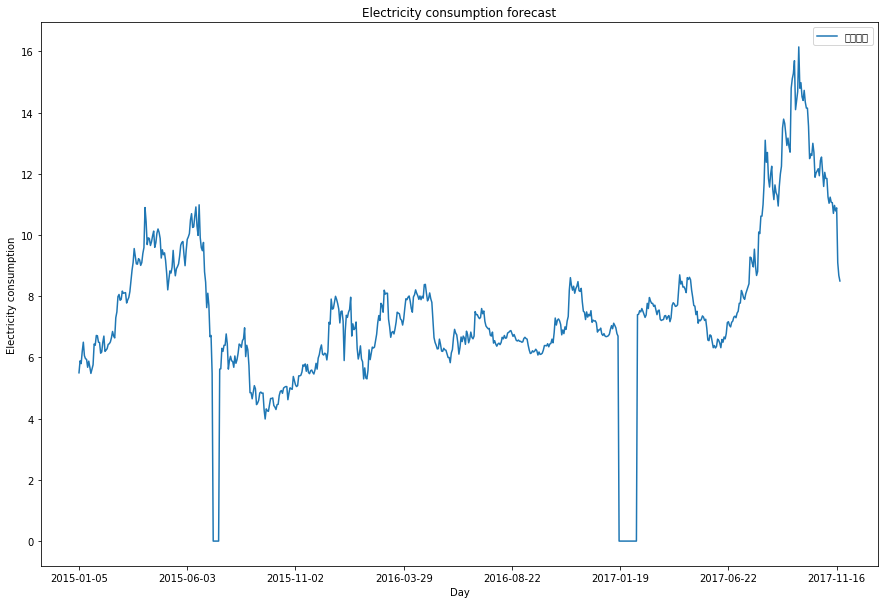

In [59]:
# 画图
fig = plt.figure(1,figsize=[15,10])
#画图
stock['今日开盘'].plot()
#图标签
plt.ylabel('Electricity consumption')
plt.xlabel('Day')
plt.title('Electricity consumption forecast')
plt.legend()
plt.show()

## (3)天气状况

In [60]:
weather.head()

,时间,温度,湿度
0,2015/10/01 00:00,16.0,88%
1,2015/10/01 01:00,16.0,94%
2,2015/10/01 02:00,16.0,94%
3,2015/10/01 02:00,17.0,95%
4,2015/10/01 03:00,16.0,94%


In [61]:
weather["时间"] = weather["时间"].str.replace('24:00', '00:00')

In [62]:
weather["时间"] = weather["时间"].str.replace('24:00', '00:00')
weather["时间"] = pd.to_datetime(weather["时间"])
weather.index = weather['时间']

In [63]:
weather['湿度'] = weather['湿度'].apply(lambda x: int(x.replace('%','')))

In [64]:
weather_with_days = weather.groupby(weather.index.date).mean()
weather_with_days.index = pd.to_datetime(weather_with_days.index)

In [65]:
weather_with_days['时间'] = weather_with_days.index

In [66]:
aluminum = pd.merge_ordered(aluminum, weather_with_days, fill_method='ffill', left_by='时间')

/home/tensorflow/.pyenv/versions/3.5.3/lib/python3.5/site-packages/pandas/core/reshape/merge.py:85: FutureWarning: '时间' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  lby = left.groupby(by, sort=False)


In [67]:
aluminum = aluminum.fillna(method='bfill')

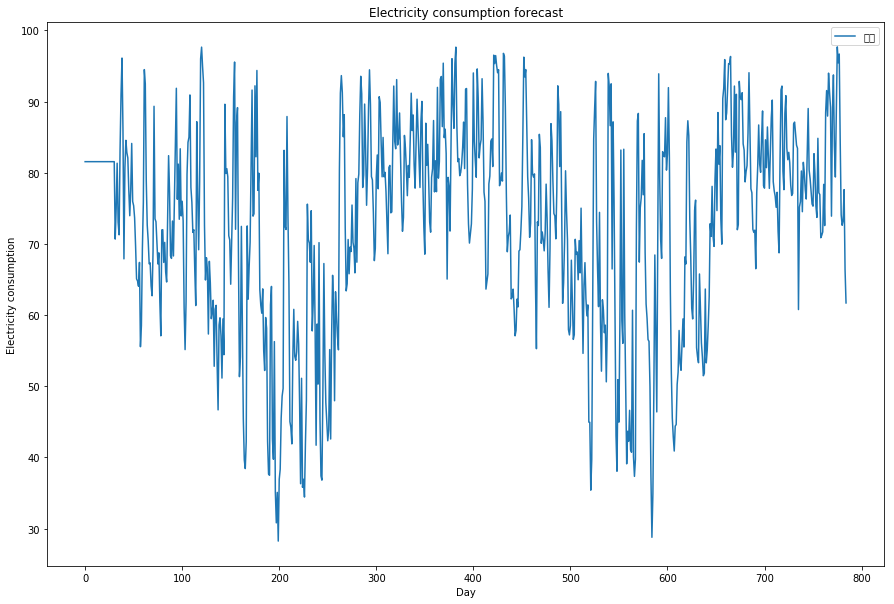

In [68]:
# 画图
fig = plt.figure(1,figsize=[15,10])
#画图
aluminum['湿度'].plot()
#图标签
plt.ylabel('Electricity consumption')
plt.xlabel('Day')
plt.title('Electricity consumption forecast')
plt.legend()
plt.show()

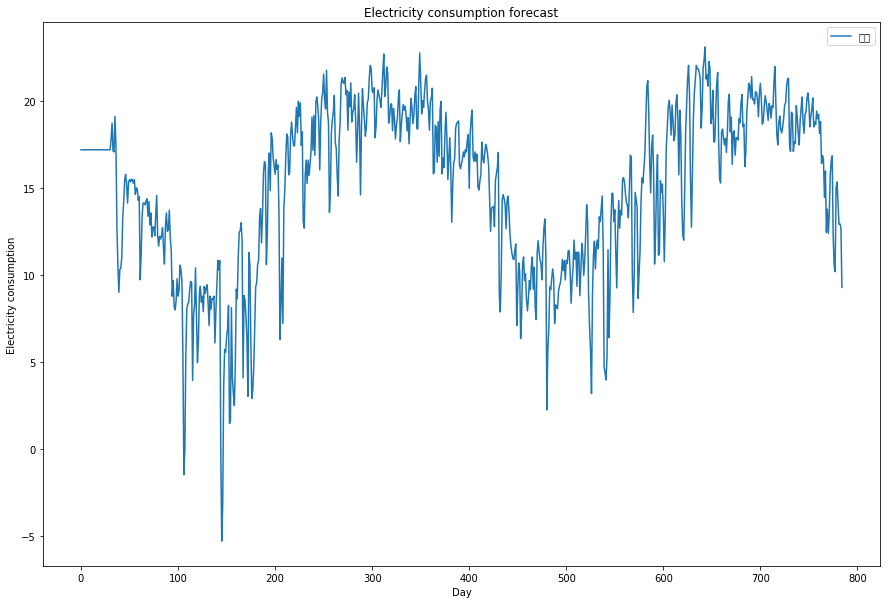

In [69]:
# 画图
fig = plt.figure(1,figsize=[15,10])
#画图
aluminum['温度'].plot()
#图标签
plt.ylabel('Electricity consumption')
plt.xlabel('Day')
plt.title('Electricity consumption forecast')
plt.legend()
plt.show()

## (4)铝的期货数据

In [298]:
import abupy

In [299]:
abupy.env.g_market_source = abupy.EMarketSourceType.E_MARKET_SOURCE_sn_futures

In [303]:
data = abupy.ABuSymbolPd.make_kl_df('AL0')
aluminum_futures = data.loc['20150102':'20170104','close']

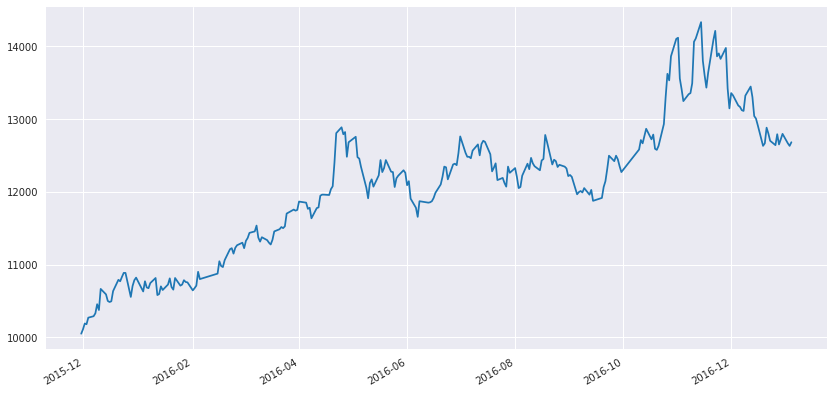

In [304]:
aluminum_futures.plot()

# 二、探索性分析

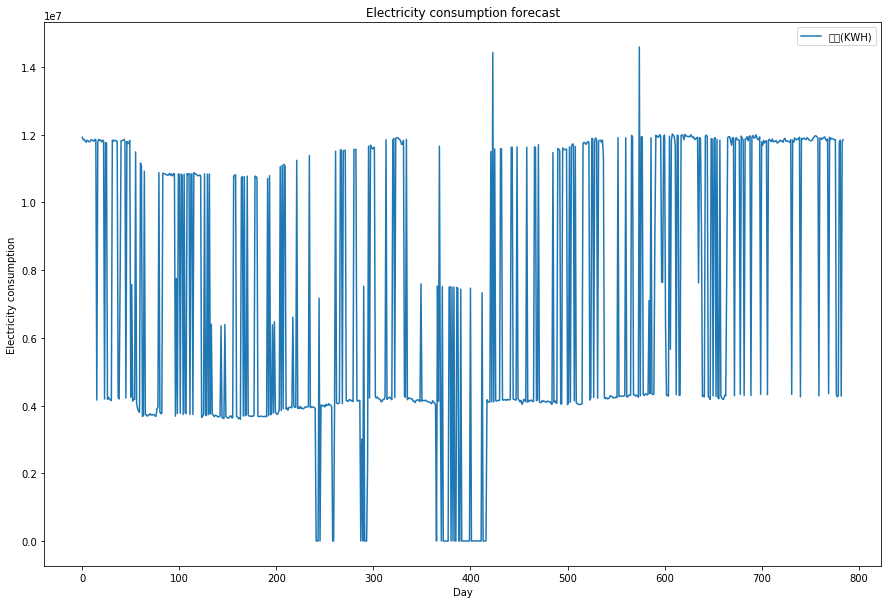

In [70]:
# 画图
fig = plt.figure(1,figsize=[15,10])
#画图
aluminum['电量(KWH)'].plot()
#图标签
plt.ylabel('Electricity consumption')
plt.xlabel('Day')
plt.title('Electricity consumption forecast')
plt.legend()
plt.show()

## 绘制直方分布图

可以看出用电量直方图中，用电量主要集中在1500~200之间

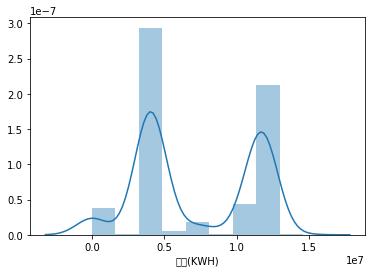

In [71]:
sns.distplot(aluminum['电量(KWH)'])

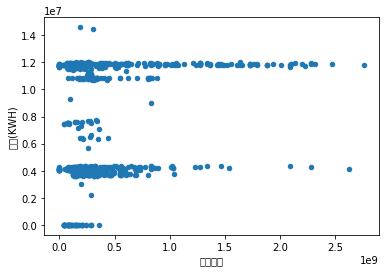

In [72]:
aluminum.plot.scatter(x='成交金额', y='电量(KWH)')

## 时间特征可视化探索

对用电量的时间特征做分析，从月份到星期到日做可视化分析:

**(1)各月用电量**

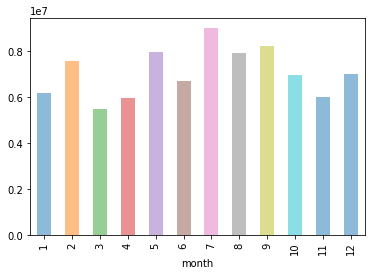

In [73]:
aluminum_month = aluminum.groupby('month').mean()
aluminum_month['电量(KWH)'].plot(kind='bar', alpha=0.5)

**(2)星期的用电量平均值**

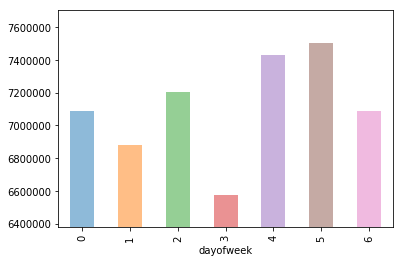

In [74]:
aluminum_dayofweek = aluminum.groupby('dayofweek').mean()
min_aluminum_dayofweek = min(aluminum_dayofweek['电量(KWH)'])
max_aluminum_dayofweek = max(aluminum_dayofweek['电量(KWH)'])
aluminum_dayofweek['电量(KWH)'].plot(kind='bar', alpha=0.5, ylim=(min_aluminum_dayofweek-200000,max_aluminum_dayofweek+200000))

**(3)个月份天数的用电量平均值**

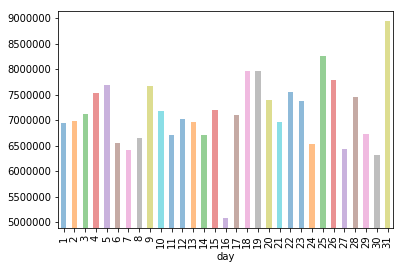

In [75]:
aluminum_day = aluminum.groupby('day').mean()
min_aluminum_day = min(aluminum_day['电量(KWH)'])
max_aluminum_day = max(aluminum_day['电量(KWH)'])
aluminum_day['电量(KWH)'].plot(kind='bar', alpha=0.5, ylim=(min_aluminum_day-200000,max_aluminum_day+200000))

**(3)节假日用电量平均值**

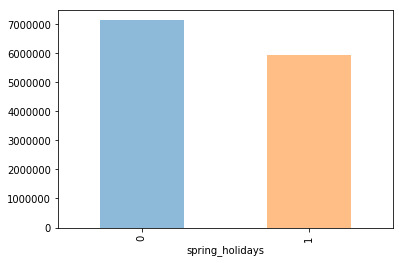

In [76]:
aluminum_holiday = aluminum.groupby('spring_holidays').mean()
aluminum_holiday['电量(KWH)'].plot(kind='bar', alpha=0.5)

### 相关性探索

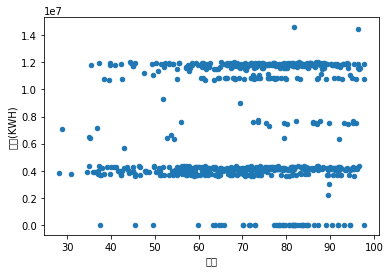

In [77]:
aluminum.plot.scatter(x='湿度', y='电量(KWH)')

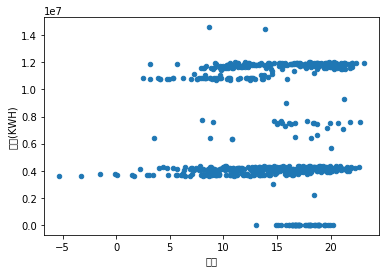

In [78]:
aluminum.plot.scatter(x='温度', y='电量(KWH)')

# 三、模型分析

模型选取、评估指标选取

## 标准化

In [79]:
max_power = max(aluminum['电量(KWH)'])
aluminum['电量(KWH)'] = aluminum['电量(KWH)']/max_power

## 傅里叶变化

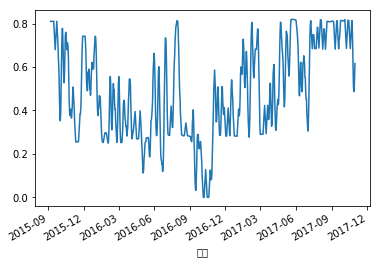

In [292]:
aluminum_windows7 = aluminum['电量(KWH)'].rolling(window=7, win_type='triang').mean()
aluminum_windows7 = aluminum_windows7.dropna()
aluminum_windows7.plot()

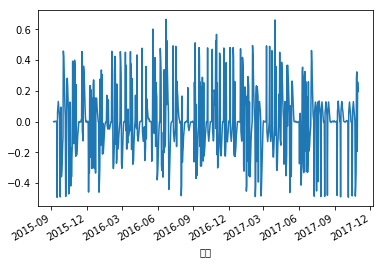

In [293]:
moving_avg_diff = aluminum['电量(KWH)']-aluminum_windows7
moving_avg_diff.plot()

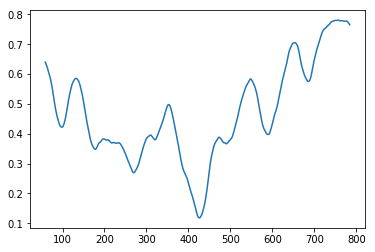

In [109]:
aluminum_windows60= aluminum['电量(KWH)'].rolling(window=60, win_type='triang').mean()
#aluminum_windows14 = aluminum_windows14.dropna()
aluminum_windows60.plot()

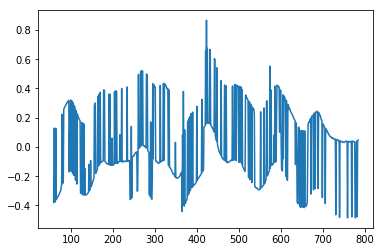

In [110]:
moving_avg_diff = aluminum['电量(KWH)']-aluminum_windows60
moving_avg_diff.plot()

## 构建时序特征

In [80]:
def shift_n(data, cols, n, dropna=True):
    all_cols,names = list(),list()
    for i in range(n, 0 ,-1):#从大到小
        all_cols.append(data[cols].shift(i))
        names += [('%s(t-%d)' % (cols[j], i)) for j in range(len(cols))]
    agg = pd.concat(all_cols, axis=1)
    agg.columns = names
    if dropna:
        agg.dropna(inplace=True)
    return agg

def shift_n_bool(data, cols, n, dropna=True):
    all_cols,names = list(),list()
    for i in range(n, 0 ,-1):#从大到小
        all_cols.append(data[cols].shift(i)>data['windows14'])
    agg = pd.concat(all_cols, axis=1)
    if dropna:
        agg.dropna(inplace=True)
    return agg

In [90]:
aluminum_windows7 = aluminum['电量(KWH)'].rolling(window=7, win_type='triang').mean()
aluminum_windows14 = aluminum['电量(KWH)'].rolling(window=14, win_type='triang').mean()
aluminum_windows7max = aluminum['电量(KWH)'].rolling(window=7).aggregate(np.max)
aluminum_windows14max = aluminum['电量(KWH)'].rolling(window=14).aggregate(np.max)
aluminum_windows7min = aluminum['电量(KWH)'].rolling(window=7).aggregate(np.min)
aluminum_windows14min = aluminum['电量(KWH)'].rolling(window=14).aggregate(np.min)
aluminum_windows = pd.concat([aluminum_windows7, aluminum_windows14,
                              aluminum_windows7max,aluminum_windows14max,
                             aluminum_windows7min,aluminum_windows14min], axis=1)
aluminum_windows.columns = ['windows7', 'windows14','windows7max','windows14max','windows7min','windows14min']
aluminum_windows = pd.concat([aluminum, aluminum_windows], axis=1)
aluminum_windows.tail()

,时间,电量(KWH),month,dayofweek,day,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,涨跌幅,成交金额,windows7,windows14,windows7max,windows14max,windows7min,windows14min
时间,,,,,,,,,,,,,,,,,,
2017-10-27,2017-10-27,0.807093,10,4,27,0,0,0,12.64,29806.0,-3.2437,6.218267e+08,0.520780,0.707872,0.813565,0.817267,0.291919,0.291919
2017-10-28,2017-10-28,0.811389,10,5,28,0,0,0,12.64,29806.0,-3.2437,6.218267e+08,0.487708,0.686330,0.812264,0.817267,0.291919,0.291919
2017-10-29,2017-10-29,0.293310,10,6,29,1,0,0,12.64,29806.0,-3.2437,6.218267e+08,0.487326,0.659449,0.812264,0.817267,0.291919,0.291919
2017-10-30,2017-10-30,0.809296,10,0,30,1,0,0,12.23,31215.0,-5.2330,6.091802e+08,0.551437,0.622013,0.811389,0.817267,0.291919,0.291919
2017-10-31,2017-10-31,0.812210,10,1,31,0,0,0,11.59,24911.0,3.0198,5.240993e+08,0.616192,0.589884,0.812210,0.815077,0.291919,0.291919


In [91]:
all_cols = list()
for i in range(14, 0 ,-1):
    all_cols.append(aluminum_windows['电量(KWH)'].shift(i)>aluminum_windows['windows14'])
aluminum_windows = pd.concat([aluminum_windows]+all_cols, axis=1)
aluminum_windows.head()

,时间,电量(KWH),month,dayofweek,day,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,...,4,5,6,7,8,9,10,11,12,13
时间,,,,,,,,,,,,,,,,,,,,,
2015-09-01,2015-09-01,0.817201,9,1,1,0,0,0,4.95,9167.0,...,False,False,False,False,False,False,False,False,False,False
2015-09-02,2015-09-02,0.812129,9,2,2,0,0,0,4.68,9106.0,...,False,False,False,False,False,False,False,False,False,False
2015-09-03,2015-09-03,0.812816,9,3,3,1,1,0,4.68,9106.0,...,False,False,False,False,False,False,False,False,False,False
2015-09-04,2015-09-04,0.809184,9,4,4,1,1,0,4.68,9106.0,...,False,False,False,False,False,False,False,False,False,False
2015-09-05,2015-09-05,0.807027,9,5,5,1,1,0,4.68,9106.0,...,False,False,False,False,False,False,False,False,False,False


In [92]:
aluminum_shift7 = shift_n(aluminum,['电量(KWH)'],7,False)
aluminum_shift7 = pd.concat([aluminum, aluminum_shift7], axis=1) 

In [93]:
aluminum_shift7.head()

,时间,电量(KWH),month,dayofweek,day,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,涨跌幅,成交金额,电量(KWH)(t-7),电量(KWH)(t-6),电量(KWH)(t-5),电量(KWH)(t-4),电量(KWH)(t-3),电量(KWH)(t-2),电量(KWH)(t-1)
时间,,,,,,,,,,,,,,,,,,,
2015-09-01,2015-09-01,0.817201,9,1,1,0,0,0,4.95,9167.0,-5.4545,1.089553e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-02,2015-09-02,0.812129,9,2,2,0,0,0,4.68,9106.0,-4.9145,9.055035e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.817201
2015-09-03,2015-09-03,0.812816,9,3,3,1,1,0,4.68,9106.0,-4.9145,9.055035e+07,NaN,NaN,NaN,NaN,NaN,0.817201,0.812129
2015-09-04,2015-09-04,0.809184,9,4,4,1,1,0,4.68,9106.0,-4.9145,9.055035e+07,NaN,NaN,NaN,NaN,0.817201,0.812129,0.812816
2015-09-05,2015-09-05,0.807027,9,5,5,1,1,0,4.68,9106.0,-4.9145,9.055035e+07,NaN,NaN,NaN,0.817201,0.812129,0.812816,0.809184


In [94]:
#删除Nan数据
aluminum_windows = aluminum_windows.dropna()

In [95]:
aluminum_windows.columns

Index([                    '时间',                '电量(KWH)',
                        'month',              'dayofweek',
                          'day',                'holiday',
       'holiday_without_weekly',        'spring_holidays',
                         '昨日收盘',                    '总笔数',
                          '涨跌幅',                   '成交金额',
                     'windows7',              'windows14',
                  'windows7max',           'windows14max',
                  'windows7min',           'windows14min',
                              0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11,
                             12,                       13],
      dtype='object')

划分“测试数据”和“训练数据”，划分时间点以2017-7-21为分割点

In [145]:
train = aluminum_windows[aluminum_windows['时间']<=pd.Timestamp('20170701')]
test = aluminum_windows[aluminum_windows['时间']>pd.Timestamp('20170601')]

## ARIMA模型

In [135]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa

In [139]:
lag_acf=acf(moving_avg_diff.dropna(),nlags=20)
lag_pacf=pacf(moving_avg_diff.dropna(),nlags=20,method='ols')

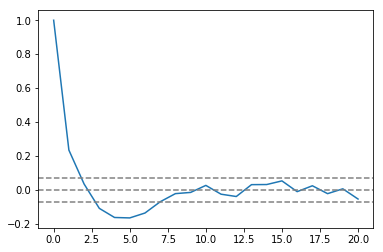

In [140]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_avg_diff.dropna())),linestyle='--',color='gray')#lowwer置信区间
plt.axhline(y=1.96/np.sqrt(len(moving_avg_diff.dropna())),linestyle='--',color='gray')#upper置信区间

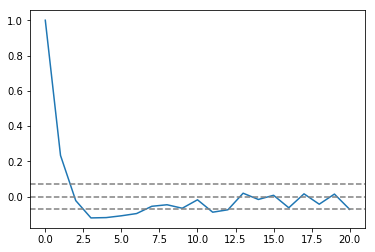

In [141]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_avg_diff.dropna())),linestyle='--',color='gray')#lowwer置信区间
plt.axhline(y=1.96/np.sqrt(len(moving_avg_diff.dropna())),linestyle='--',color='gray')#upper置信区间

In [126]:
aluminum.index = aluminum['时间']

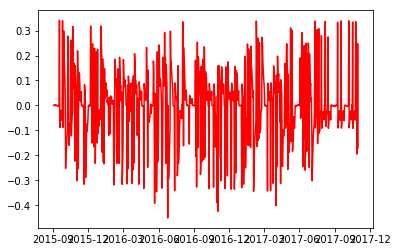

In [263]:
#AR model
model=ARIMA(aluminum['电量(KWH)'],order=(7,1,0))
result_AR=model.fit(disp=-1)
plt.plot(result_AR.fittedvalues,color='red')

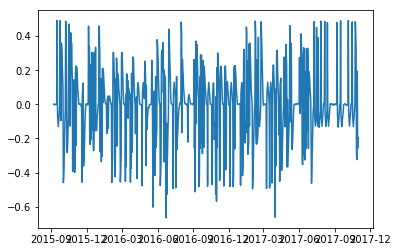

In [246]:
plt.plot( - moving_avg_diff)

In [ ]:
aluminum

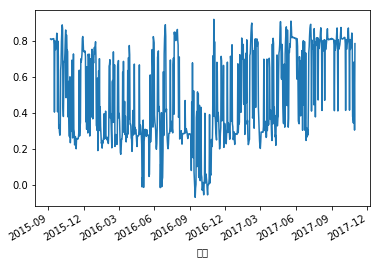

In [270]:
pred = aluminum_windows7-result_AR.fittedvalues
pred.plot()

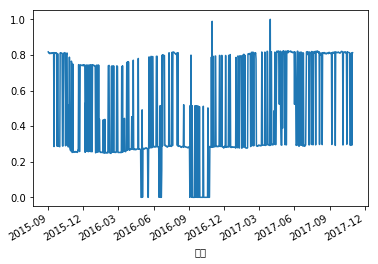

In [265]:
aluminum['电量(KWH)'].plot()

In [271]:
result = pd.concat([pred, aluminum['电量(KWH)']],axis=1,join='inner')

In [272]:
result = result.dropna()

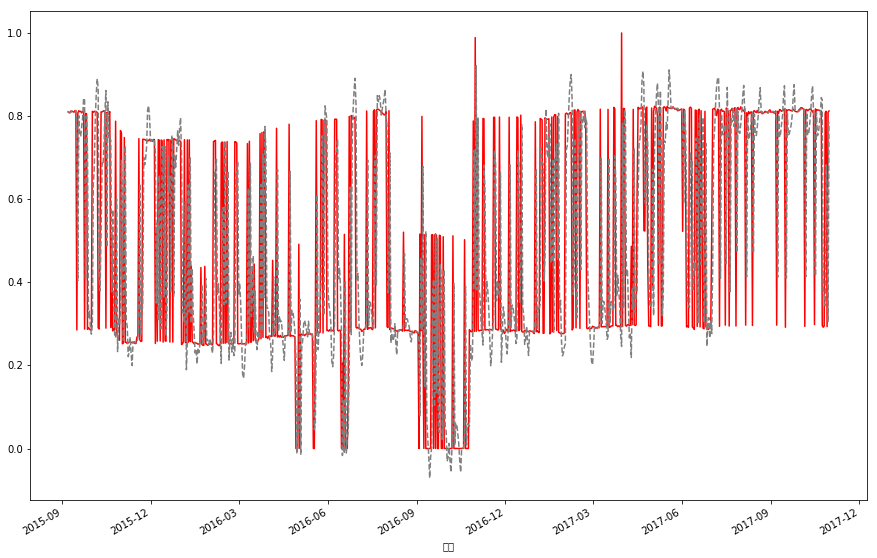

In [273]:
fig = plt.figure(1,figsize=[15,10])
result['电量(KWH)'].plot(color='red')
result[0].plot(linestyle='--',color='gray')

In [274]:
mean_squared_error(result[0], result['电量(KWH)'])

0.055885208029249615

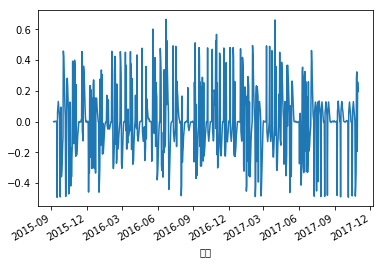

In [239]:
moving_avg_diff = aluminum['电量(KWH)']-aluminum_windows7
moving_avg_diff.plot()

In [148]:
for i in range(1,7):
    arma_mod20 = ARIMA(aluminum['电量(KWH)'],(i,0,0)).fit()
    print(i, arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)

1 -57.66229706230706 -43.665245909 -52.2804618722
2 -112.25826480106025 -93.5955299299 -105.082484548
3 -136.0867814274593 -112.758362839 -127.117056111
4 -142.73968998711598 -114.74558768 -131.976019607
5 -145.24848760222312 -112.588701578 -132.690872159
6 -145.51869567497624 -108.193225933 -131.167135168


### (1)模型一，基准模型，用xgboost的对数据进行预测。

In [146]:
valid_cols = [ '电量(KWH)',
                        'month',              'dayofweek',
                          'holiday',
       'holiday_without_weekly',        'spring_holidays',
                          '总笔数',
                          '涨跌幅',                   '成交金额',
                     'windows7',              'windows14',
                  'windows7max',           'windows14max',
                  'windows7min',           'windows14min',
                              0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11,
                             12,                       13
             ]
train = train[valid_cols]
test = test[valid_cols]

In [147]:
train_y = train['电量(KWH)'].values
train_x = train.drop('电量(KWH)',axis=1)
test_y = test['电量(KWH)'].values
test_x = test.drop('电量(KWH)',axis=1)

In [148]:
train_x

,month,dayofweek,holiday,holiday_without_weekly,spring_holidays,总笔数,涨跌幅,成交金额,windows7,windows14,...,4,5,6,7,8,9,10,11,12,13
时间,,,,,,,,,,,,,,,,,,,,,
2015-09-14,9,0,1,0,0,11231.0,-9.9379,1.430350e+08,0.810625,0.809979,...,False,False,True,False,False,False,True,True,True,False
2015-09-15,9,1,0,0,0,9170.0,-9.4253,9.737898e+07,0.810940,0.809972,...,False,True,False,False,False,True,True,True,False,True
2015-09-16,9,2,0,0,0,8157.0,9.8985,9.500585e+07,0.778245,0.804805,...,True,True,True,True,True,True,True,True,True,True
2015-09-17,9,3,0,0,0,9826.0,-1.8476,1.271866e+08,0.745373,0.794291,...,True,True,True,True,True,True,True,True,True,False
2015-09-18,9,4,0,0,0,5481.0,0.9412,6.241555e+07,0.712453,0.783725,...,True,True,True,True,True,True,True,True,False,True
2015-09-19,9,5,0,0,0,5481.0,0.9412,6.241555e+07,0.679393,0.773115,...,True,True,True,True,True,True,True,False,True,True
2015-09-20,9,6,1,0,0,5481.0,0.9412,6.241555e+07,0.712040,0.762511,...,True,True,True,True,True,True,False,True,True,True
2015-09-21,9,0,1,0,0,5366.0,2.5641,6.314023e+07,0.744866,0.751871,...,True,True,True,True,True,False,True,True,True,True
2015-09-22,9,1,0,0,0,9809.0,10.0000,1.793180e+08,0.777602,0.741097,...,True,True,True,True,False,True,True,True,True,True


In [149]:
import xgboost as xgb
params = {
        'learning_rate': 0.01,
        'max_depth': 9,
        'objective': 'reg:linear',
        'n_estimators': 1000,
        'seed': 0,
    }
clf_xgb_without_weight = xgb.XGBRegressor(**params)

In [150]:
eval_set=[(train_x, train_y), (test_x, test_y)]
clf_xgb_without_weight.fit(train_x, train_y, 
                           eval_set=eval_set,
                           early_stopping_rounds=100, 
                           eval_metric='rmse',
                           verbose=20
                          )

[0]	validation_0-rmse:0.271537	validation_1-rmse:0.290193
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[20]	validation_0-rmse:0.234539	validation_1-rmse:0.261977
[40]	validation_0-rmse:0.203616	validation_1-rmse:0.241313
[60]	validation_0-rmse:0.177041	validation_1-rmse:0.227386
[80]	validation_0-rmse:0.155188	validation_1-rmse:0.218746
[100]	validation_0-rmse:0.137659	validation_1-rmse:0.210247
[120]	validation_0-rmse:0.120221	validation_1-rmse:0.200439
[140]	validation_0-rmse:0.106456	validation_1-rmse:0.194661
[160]	validation_0-rmse:0.094728	validation_1-rmse:0.190516
[180]	validation_0-rmse:0.084748	validation_1-rmse:0.188151
[200]	validation_0-rmse:0.075567	validation_1-rmse:0.188018
[220]	validation_0-rmse:0.068361	validation_1-rmse:0.18734
[240]	validation_0-rmse:0.062031	validation_1-rmse:0.184292
[260]	validation_0-rmse:0.056371	validation_1-rmse:0.18288
[280]	va

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## 回测数据

In [157]:
pred_y = clf_xgb_without_weight.predict(train_x)

In [159]:
mean_squared_error(train_y, pred_y)

0.003402032123323405

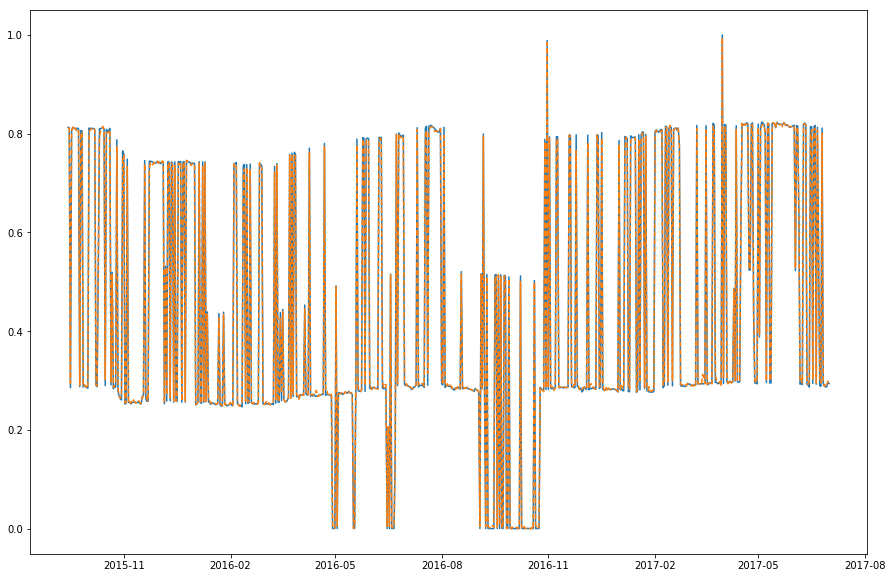

In [160]:
# 画图
fig = plt.figure(1,figsize=[15,10])
plt.plot(train.index, train_y)
plt.plot(train.index, pred_y, '--')
plt.show()

## 使用模型预测未来数据

In [153]:
pred_y = clf_xgb_without_weight.predict(test_x)

In [154]:
from sklearn.metrics import mean_absolute_error

In [155]:
mean_absolute_error(test_y, pred_y)

0.12437901157654897

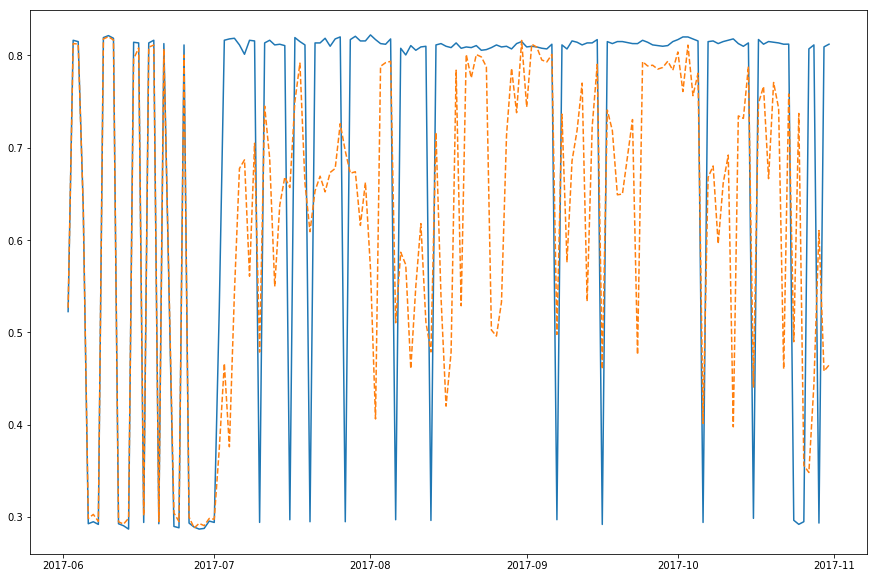

In [156]:
# 画图
fig = plt.figure(1,figsize=[15,10])
plt.plot(test.index, test_y)
plt.plot(test.index, pred_y, '--')
plt.show()

### 转换为分类问题

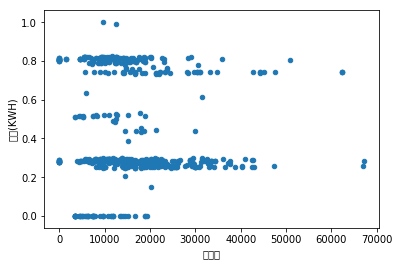

In [31]:
train.plot.scatter(x='总笔数', y='电量(KWH)')

In [36]:
def classfy_power(num):
    if num <0.2:
        return 1
    elif 0.2<=num<0.4:
        return 2
    elif 0.4<=num<0.6:
        return 3
    else:
        return 4
train['power'] = train['电量(KWH)'].apply(classfy_power)
test['power'] = test['电量(KWH)'].apply(classfy_power)
train.head()

/home/tensorflow/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/tensorflow/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,时间,电量(KWH),month,dayofweek,day,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,...,5,6,7,8,9,10,11,12,13,power
时间,,,,,,,,,,,,,,,,,,,,,
2015-09-14,2015-09-14,0.812868,9,0,14,1,0,0,4.83,11231.0,...,False,True,False,False,False,True,True,True,False,4
2015-09-15,2015-09-15,0.812142,9,1,15,0,0,0,4.35,9170.0,...,True,False,False,False,True,True,True,False,True,4
2015-09-16,2015-09-16,0.285341,9,2,16,0,0,0,3.94,8157.0,...,True,True,True,True,True,True,True,True,True,2
2015-09-17,2015-09-17,0.807073,9,3,17,0,0,0,4.33,9826.0,...,True,True,True,True,True,True,True,True,False,4
2015-09-18,2015-09-18,0.812847,9,4,18,0,0,0,4.25,5481.0,...,True,True,True,True,True,True,True,False,True,4


In [37]:
train.columns

Index([                    '时间',                '电量(KWH)',
                        'month',              'dayofweek',
                          'day',                'holiday',
       'holiday_without_weekly',        'spring_holidays',
                         '昨日收盘',                    '总笔数',
                          '涨跌幅',                   '成交金额',
                     'windows7',              'windows14',
                  'windows7max',           'windows14max',
                  'windows7min',           'windows14min',
                              0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11,
                             12,                       13,
                        'power'],
      dtype='object')

In [42]:
valid_cols = [                        'month',              'dayofweek','holiday','spring_holidays',
                         '昨日收盘',                    '总笔数',
                          '涨跌幅',                   '成交金额',
                     'windows7',              'windows14',
                  'windows7max',           'windows14max',
                  'windows7min',           'windows14min',
                              0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11,
                             12,                       13,
                        'power'
             ]
train = train[valid_cols]
test = test[valid_cols]
train_x = train.drop('power',axis=1)
test_x = test.drop('power',axis=1)
train_y = train['power']
test_y = test['power']

In [43]:
import xgboost as xgb
params = {
        'learning_rate': 0.025,
        'max_depth': 6,
        'objective': 'multi:softmax',
        #'eval_metric': 'logloss',
        'n_estimators': 500,
        'seed': i,
        #'silent': True
    }
clf_xgb_with_classfy = xgb.XGBClassifier(**params)

In [44]:
eval_set=[(train_x, train_y), (test_x, test_y)]
clf_xgb_with_classfy.fit(train_x, train_y, 
                           eval_set=eval_set,
                           early_stopping_rounds=100, 
                           eval_metric='merror',
                           verbose=20
                          )

[0]	validation_0-merror:0.136713	validation_1-merror:0.702479
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[20]	validation_0-merror:0.109063	validation_1-merror:0.190083
[40]	validation_0-merror:0.09831	validation_1-merror:0.190083
[60]	validation_0-merror:0.09063	validation_1-merror:0.198347
[80]	validation_0-merror:0.081413	validation_1-merror:0.214876
[100]	validation_0-merror:0.066052	validation_1-merror:0.22314
Stopping. Best iteration:
[7]	validation_0-merror:0.133641	validation_1-merror:0.157025



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.025, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [45]:
clf_xgb_with_classfy.predict(test_x)

array([2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3,
       4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4,
       2, 2, 2, 2, 2, 4])

In [46]:
test_y

时间
2017-07-02    3
2017-07-03    4
2017-07-04    4
2017-07-05    4
2017-07-06    4
2017-07-07    4
2017-07-08    4
2017-07-09    4
2017-07-10    2
2017-07-11    4
2017-07-12    4
2017-07-13    4
2017-07-14    4
2017-07-15    4
2017-07-16    2
2017-07-17    4
2017-07-18    4
2017-07-19    4
2017-07-20    2
2017-07-21    4
2017-07-22    4
2017-07-23    4
2017-07-24    4
2017-07-25    4
2017-07-26    4
2017-07-27    2
2017-07-28    4
2017-07-29    4
2017-07-30    4
2017-07-31    4
             ..
2017-10-02    4
2017-10-03    4
2017-10-04    4
2017-10-05    4
2017-10-06    2
2017-10-07    4
2017-10-08    4
2017-10-09    4
2017-10-10    4
2017-10-11    4
2017-10-12    4
2017-10-13    4
2017-10-14    4
2017-10-15    4
2017-10-16    2
2017-10-17    4
2017-10-18    4
2017-10-19    4
2017-10-20    4
2017-10-21    4
2017-10-22    4
2017-10-23    4
2017-10-24    2
2017-10-25    2
2017-10-26    2
2017-10-27    4
2017-10-28    4
2017-10-29    2
2017-10-30    4
2017-10-31    4
Name: power, Length: 

### (2)模型二，基于循环神经网络模型，用LSTM算法预测企业用电规律。

In [37]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func = "linear",
                dropout =0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [38]:
training_set = aluminum[aluminum['时间']<=pd.Timestamp('20170701')]
test_set = aluminum[aluminum['时间']>pd.Timestamp('20170701')]
training_set = training_set.drop('时间',axis=1)
test_set = test_set.drop('时间',axis=1)
training_set = training_set.drop('day',axis=1)
test_set = test_set.drop('day',axis=1)

In [58]:
#去零
for c in training_set.columns:
    training_set[c] = training_set[c].apply(lambda x: 0.0000001 if x==0 else x)
for c in test_set.columns:
    test_set[c] = test_set[c].apply(lambda x: 0.0000001 if x==0 else x)

In [46]:
training_set.head()

,电量(KWH),month,dayofweek,holiday,holiday_without_weekly,spring_holidays,昨日收盘,总笔数,涨跌幅,成交金额
时间,,,,,,,,,,
2015-09-01,0.817201,9,1.0,1.000000e-07,1.000000e-07,1.000000e-07,4.95,9167.0,-5.4545,1.089553e+08
2015-09-02,0.812129,9,2.0,1.000000e-07,1.000000e-07,1.000000e-07,4.68,9106.0,-4.9145,9.055035e+07
2015-09-03,0.812816,9,3.0,1.000000e+00,1.000000e+00,1.000000e-07,4.68,9106.0,-4.9145,9.055035e+07
2015-09-04,0.809184,9,4.0,1.000000e+00,1.000000e+00,1.000000e-07,4.68,9106.0,-4.9145,9.055035e+07
2015-09-05,0.807027,9,5.0,1.000000e+00,1.000000e+00,1.000000e-07,4.68,9106.0,-4.9145,9.055035e+07


In [47]:
window_len = 10
np.random.seed(202)
norm_cols = ['电量(KWH)','昨日收盘','总笔数','涨跌幅','成交金额','month','dayofweek']
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

In [48]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

In [75]:
LSTM_training_inputs.shape

(654, 10, 10)

In [90]:
train_x_1 = np.array([np.array([i]) for i in train_x.values])
train_x_1.shape

(651, 1, 28)

In [95]:
def build_model(inputs, output_size, neurons, activ_func = "linear",
                dropout =0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

eth_model = build_model(train_x_1, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(train_x_1, train_y, 
                            epochs=20, batch_size=1, verbose=2, shuffle=True)

Epoch 1/30
4s - loss: 0.2561
Epoch 2/30
3s - loss: 0.2198
Epoch 3/30
3s - loss: 0.2089
Epoch 4/30
3s - loss: 0.2037
Epoch 5/30
3s - loss: 0.2000
Epoch 6/30
3s - loss: 0.1990
Epoch 7/30
3s - loss: 0.1983
Epoch 8/30
3s - loss: 0.1985
Epoch 9/30
3s - loss: 0.1968
Epoch 10/30
3s - loss: 0.1985
Epoch 11/30
3s - loss: 0.1980
Epoch 12/30
3s - loss: 0.1983
Epoch 13/30
3s - loss: 0.1982
Epoch 14/30
3s - loss: 0.1966
Epoch 15/30
3s - loss: 0.1973
Epoch 16/30
3s - loss: 0.1968
Epoch 17/30
3s - loss: 0.1950
Epoch 18/30
3s - loss: 0.1950
Epoch 19/30
3s - loss: 0.1954
Epoch 20/30
3s - loss: 0.1966
Epoch 21/30
3s - loss: 0.1951
Epoch 22/30
3s - loss: 0.1961
Epoch 23/30
3s - loss: 0.1960
Epoch 24/30
3s - loss: 0.1952
Epoch 25/30
3s - loss: 0.1951
Epoch 26/30
3s - loss: 0.1961
Epoch 27/30
3s - loss: 0.1955
Epoch 28/30
3s - loss: 0.1940
Epoch 29/30
3s - loss: 0.1943
Epoch 30/30
3s - loss: 0.1954


In [96]:
test_x_1 = np.array([np.array([i]) for i in test_x.values])
pred_y = eth_model.predict(test_x_1)

In [99]:
pred_y.resize(pred_y.shape[0])

In [103]:
len(pred_y)

121

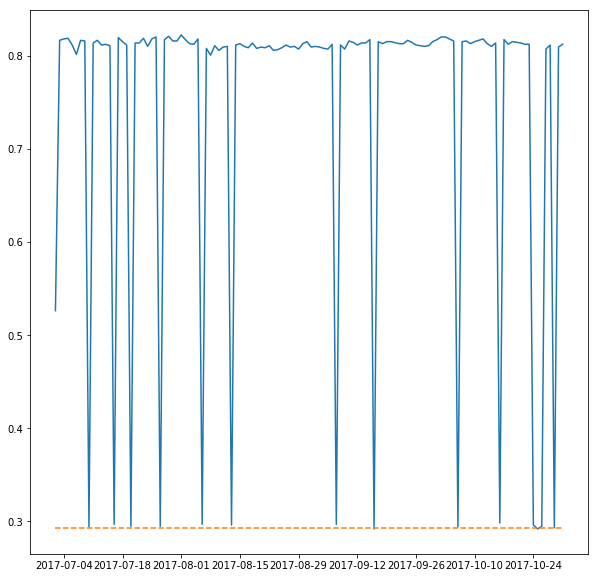

In [104]:
# 画图
fig = plt.figure(1,figsize=[10,10])
plt.plot(test.index, test_y)
plt.plot(test.index, pred_y, '--')
plt.show()

In [57]:
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = training_set['电量(KWH)'][window_len:].values
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=30, batch_size=1, verbose=2, shuffle=True)

Epoch 1/30
11s - loss: 0.3632
Epoch 2/30
10s - loss: 0.2596
Epoch 3/30
10s - loss: 0.2439
Epoch 4/30
10s - loss: 0.2429
Epoch 5/30
10s - loss: 0.2260
Epoch 6/30
10s - loss: 0.2226
Epoch 7/30
10s - loss: 0.2109
Epoch 8/30
10s - loss: 0.2087
Epoch 9/30
10s - loss: 0.2070
Epoch 10/30
10s - loss: 0.2015
Epoch 11/30
10s - loss: 0.2032
Epoch 12/30
10s - loss: 0.1999
Epoch 13/30
10s - loss: 0.1914
Epoch 14/30
10s - loss: 0.1964
Epoch 15/30
10s - loss: 0.1886
Epoch 16/30
10s - loss: 0.1901
Epoch 17/30
10s - loss: 0.1865
Epoch 18/30
10s - loss: 0.1881
Epoch 19/30
10s - loss: 0.1847
Epoch 20/30
10s - loss: 0.1815
Epoch 21/30
10s - loss: 0.1776
Epoch 22/30
10s - loss: 0.1810
Epoch 23/30
10s - loss: 0.1774
Epoch 24/30
10s - loss: 0.1744
Epoch 25/30
10s - loss: 0.1768
Epoch 26/30
10s - loss: 0.1767
Epoch 27/30
10s - loss: 0.1761
Epoch 28/30
10s - loss: 0.1728
Epoch 29/30
10s - loss: 0.1750
Epoch 30/30
10s - loss: 0.1749


In [59]:
window_len = 10
np.random.seed(202)
norm_cols = ['电量(KWH)','昨日收盘','总笔数','涨跌幅','成交金额','month','dayofweek']
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_inputs = [np.array(LSTM_test_input) for LSTM_test_input in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [60]:
LSTM_predict_outputs = eth_model.predict(LSTM_test_inputs)

In [70]:
LSTM_predict_outputs.resize(111)

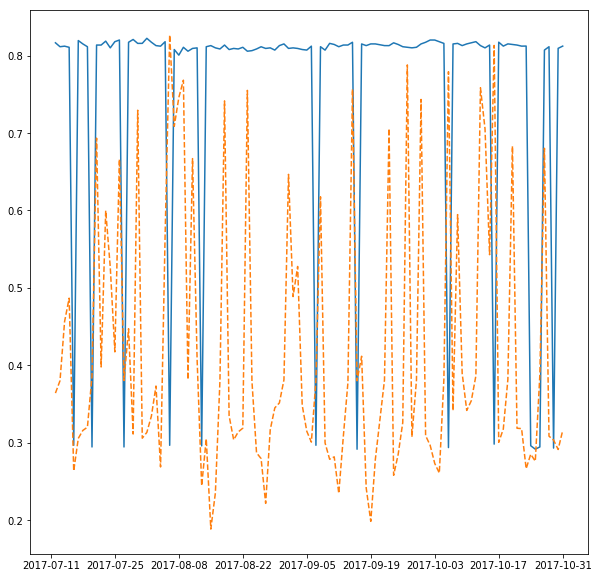

In [73]:
# 画图
fig = plt.figure(1,figsize=[10,10])
plt.plot(test.index[window_len:], test_set['电量(KWH)'].iloc[window_len:])
plt.plot(test.index[window_len:], LSTM_predict_outputs, '--')
plt.show()